### Installation librairies manquantes

In [1]:
pip install mirdata


     |████████████████████████████████| 13.1 MB 5.3 MB/s 
     |████████████████████████████████| 5.6 MB 22.5 MB/s 
     |████████████████████████████████| 51 kB 64 kB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 
     |████████████████████████████████| 87 kB 6.6 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=01ac56da69b244999378ae5b026b09e734e70ead84522f786c899342abfdc5f8
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64922 sha256=ee1ebdafe35bd987d6d36c4e4ecbed153aacce386621620976aaac8e51150ed3
  Stored in directory: /root/.cache/pip/wheels/c9/aa/16/ce72bc4caa58dfab819e3f46b3542f2bf90a83009f4ea07a48
  Created wheel for mir-eval: filename=mir_eval-0.6-py3-none-any.whl size=96515 sha256=dc390e9a0ffaa6f6a84b01b2ac0bd5e210610d322ceb64ad401027f75d244c50
  Stored in directory: /root/.cache/pip/whe

In [2]:
pip install librosa

In [3]:
pip install revcorml --upgrade

###Importation librairies

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import SVC  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import IPython.display as ipd
import revcorml

In [5]:
import mirdata
print(mirdata.list_datasets())

['acousticbrainz_genre', 'beatles', 'beatport_key', 'billboard', 'cante100', 'compmusic_jingju_acappella', 'compmusic_otmm_makam', 'da_tacos', 'dagstuhl_choirset', 'dali', 'freesound_one_shot_percussive_sounds', 'giantsteps_key', 'giantsteps_tempo', 'good_sounds', 'groove_midi', 'gtzan_genre', 'guitarset', 'haydn_op20', 'ikala', 'irmas', 'maestro', 'medley_solos_db', 'medleydb_melody', 'medleydb_pitch', 'mridangam_stroke', 'mtg_jamendo_autotagging_moodtheme', 'orchset', 'phenicx_anechoic', 'queen', 'rwc_classical', 'rwc_jazz', 'rwc_popular', 'salami', 'saraga_carnatic', 'saraga_hindustani', 'slakh', 'tinysol', 'tonality_classicaldb', 'tonas', 'vocadito']


###Chargement dataset

In [6]:
tinysol = mirdata.initialize('tinysol')
tinysol.download()

INFO: Downloading ['audio', 'annotations'] to /root/mir_datasets/tinysol
INFO: [audio] downloading TinySOL.tar.gz
979MB [00:46, 22.0MB/s]                           
INFO: [annotations] downloading TinySOL_metadata.csv
312kB [00:02, 149kB/s]                           


In [7]:
data_ids = tinysol.track_ids
data = tinysol.load_tracks()

###Quelques visualisations du dataset

There are 2913 different notes
Acc
Accordion
Keyboards


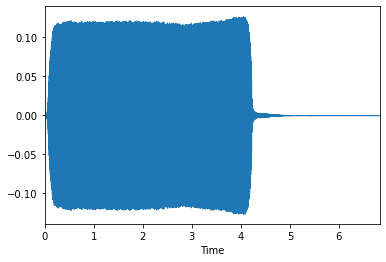

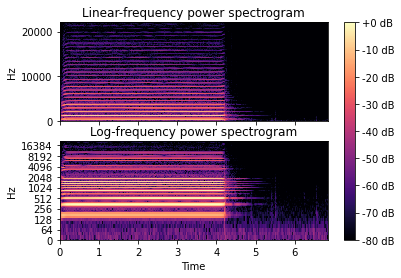

In [8]:
nb_instruments = len(data_ids)
print("There are "+str(nb_instruments)+" different notes")

instrument_number = 1000

iTrack = tinysol.track(data_ids[instrument_number])  
print(iTrack.instrument_abbr)
print(iTrack.instrument_full)
print(iTrack.family)
y = iTrack.audio[0]
sample_rate = iTrack.audio[1]
librosa.display.waveplot(y, sr=sample_rate)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sample_rate, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 512
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sample_rate, hop_length=hop_length,x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

ipd.Audio(y, rate=sample_rate)

###Pre-processing : Sélection instruments

In [27]:
nb_instruments = len(data_ids)
print("There are "+str(nb_instruments)+" different notes")
tab_label_instrument = []
tab_label_family = []
for iInstrument in range(nb_instruments):
  iTrack = tinysol.track(data_ids[iInstrument])  
  tab_label_instrument.append(iTrack.instrument_abbr)
  tab_label_family.append(iTrack.family)

print()
print(np.unique(np.asarray(tab_label_instrument)))
print(np.unique(np.asarray(tab_label_family)))
print()
indexes = np.arange(nb_instruments, dtype=np.uint8)

#indexes[np.asarray(tab_label_instrument) == ('BTb' or 'Fl')] = 1
#conditions = ['BTb', 'Fl', 'Va', 'Vc']
conditions = ['Brass', 'Strings','Winds']
tab_fft = []
tab_labels = []

for iInstrument in range(nb_instruments):
  #print(iInstrument)
  for cond in conditions:
    #if np.asarray(tab_label_instrument)[iInstrument] == cond:
    if np.asarray(tab_label_family)[iInstrument] == cond:
      iTrack = tinysol.track(data_ids[iInstrument])
      D = librosa.amplitude_to_db(np.abs(librosa.stft(iTrack.audio[0])), ref=np.max)
      tab_fft.append(np.mean(D,axis=1)) 
      tab_labels.append(cond)
      #print(np.mean(D,axis=1).shape)
      #plt.plot(np.mean(D,axis=1))
      #plt.show()
tab_fft = np.asarray(tab_fft)
tab_labels = np.asarray(tab_labels) 
print(np.asarray(tab_fft).shape)
print(np.asarray(tab_labels).shape)

There are 2913 different notes

['ASax' 'Acc' 'BTb' 'Bn' 'Cb' 'ClBb' 'Fl' 'Hn' 'Ob' 'Tbn' 'TpC' 'Va' 'Vc'
 'Vn']
['Brass' 'Keyboards' 'Strings' 'Winds']

(2224, 1025)
(2224,)


In [28]:
print(np.unique(tab_labels))

['Brass' 'Strings' 'Winds']


###Ensemble d'entrainement/ensemble de test

In [29]:
scaler = StandardScaler()
scaler.fit(tab_fft)
tab_fft_transform = scaler.transform(tab_fft) 
#tab_fft = tab_fft 
#tab_fft =  tab_fft / np.amax(tab_fft)
X_train, X_test, y_train, y_test = train_test_split(tab_fft_transform, tab_labels, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(np.unique(y_train))


(1668, 1025)
(556, 1025)
(1668,)
(556,)
['Brass' 'Strings' 'Winds']


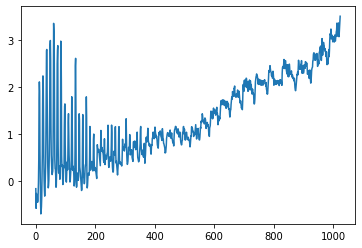

In [31]:
plt.plot(X_train[100][:])
plt.show()

###Réduction de dimensions

In [82]:
n_components = 10
pca = PCA(n_components=n_components, svd_solver='auto', whiten=True, random_state=12).fit(X_train)   
x_train_pca = pca.transform(X_train)
print("Explained variance: "+str(np.sum(pca.explained_variance_ratio_)))
print("Size x_train_pca: "+str(x_train_pca.shape))

Explained variance: 0.783828
Size x_train_pca: (1668, 10)


###Entrainement du classifieur

In [83]:
tuned_parameters = { 'gamma':np.logspace(-3,3,num=5),'C':np.logspace(-3,3,num=5)}

clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, n_jobs=-1, cv=StratifiedKFold(5),  pre_dispatch=6, scoring='balanced_accuracy', verbose=True)

clf.fit(x_train_pca, y_train)
print("Training done")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training done


###Evaluation du classifieur

####Training

In [84]:
scores = cross_val_score(SVC(kernel='rbf',gamma=clf.best_params_['gamma'], C=clf.best_params_['C']), x_train_pca, y_train, cv=StratifiedKFold(5))
print("Training accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Training accuracy: 0.85 (+/- 0.02)


####Testing

In [85]:
y_pred = clf.predict(pca.transform(X_test))
print("Testing accuracy: %0.2f" % (accuracy_score(y_test,y_pred)))
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Testing accuracy: 0.86
Confusion matrix
[[105   6  16]
 [  4 266  17]
 [ 20  13 109]]
              precision    recall  f1-score   support

       Brass       0.81      0.83      0.82       127
     Strings       0.93      0.93      0.93       287
       Winds       0.77      0.77      0.77       142

    accuracy                           0.86       556
   macro avg       0.84      0.84      0.84       556
weighted avg       0.86      0.86      0.86       556



###Interprétation du classifieur

####Additive noise

[[18638     0     0]
 [    0 14750     0]
 [    0     0 16612]]


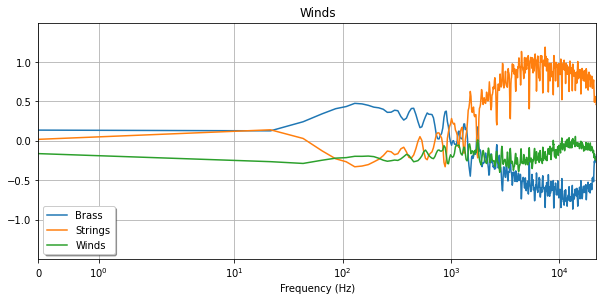

In [93]:
dimOfinput = (1,1025) # dimension of the input representation
probingMethod = 'revcor' # choice of the probing method : bubbles or revcor
samplesMethod = 'pseudoRandom' # choice of the method to generate probing samples trainSet or pseudoRandom (need x_test_set) or gaussianNoise
nbRevcorTrials = 50000 # number of probing samples for the reverse correlation (must be below the number of training sample if trainSet)
nDim_pca = 100 # number of dimension to compute the PCA for the pseudo-random noise generation
probingSamples, noises = revcorml.generateProbingSamples(x_train_set = X_train, x_test_set = X_train, dimOfinput=dimOfinput, probingMethod = probingMethod, samplesMethod = samplesMethod, nDim_pca = nDim_pca, nbRevcorTrials = nbRevcorTrials)
probingSamples.shape
frequency_vec = np.linspace(0,sample_rate/2,1025)

y_pred = clf.predict(pca.transform(probingSamples))
print(confusion_matrix(y_pred, y_pred))
canonicalMaps = revcorml.ComputeCanonicalMaps(probingSamples, y_pred, dimOfinput=dimOfinput)
plt.figure(figsize=(10,20))
np.asarray(canonicalMaps).shape
plt.subplot(4,1,1)
plt.plot(frequency_vec,canonicalMaps[0])
plt.title(conditions[0])
#plt.subplot(4,1,2)
plt.plot(frequency_vec,canonicalMaps[1])
plt.title(conditions[1])
#plt.subplot(4,1,3)
plt.plot(frequency_vec,canonicalMaps[2])
plt.title(conditions[2])
#plt.subplot(4,1,4)
#plt.plot(canonicalMaps[3])
#plt.title(conditions[3])
plt.axis([0, sample_rate/2, -1.5, 1.5])
plt.grid(True, which='both')
plt.xscale('symlog')
#plt.yscale('symlog')
plt.yticks([-1, -.5, 0, .5, 1])
plt.xlabel('Frequency (Hz)')
plt.legend((conditions[0], conditions[1], conditions[2]),
           loc='lower left', shadow=True)
plt.show()


In [ ]:
X_train.shape

(1668, 1025)



```
# Ce texte est au format code
```

####Multiplicative noise (ne fonctionne pas)

(50000, 1025)
[[  394     0     0     0]
 [    0  5159     0     0]
 [    0     0 21575     0]
 [    0     0     0 22872]]
['BTb' 'Fl' 'Va' 'Vc']
0 over 4 classes
1 over 4 classes
2 over 4 classes
3 over 4 classes
(4, 1025)


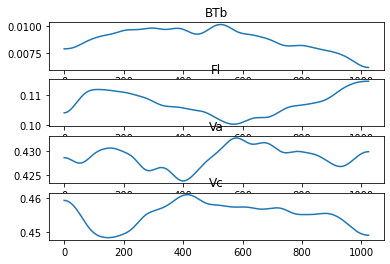

(50000, 1025)

In [ ]:
dimOfinput = (1025) # dimension of the input representation
probingMethod = 'bubbles' # choice of the probing method : bubbles or revcor
samplesMethod = 'pseudoRandom' # choice of the method to generate probing samples trainSet or pseudoRandom (need x_test_set) or gaussianNoise
#nbRevcorTrials = 200000 # number of probing samples for the reverse correlation (must be below the number of training sample if trainSet)
nbMasks = 50000 # number of trials, 
bubbleSize = [30] # bubbles standards deviations in the different dimensions
bubbleMasks, binaryMasks = revcorml.generateBubbleMask(dimOfinput = dimOfinput, nbMasks = nbMasks, probaBubbles = .5, bubbleSize = bubbleSize)

print(bubbleMasks.shape)

#x_test_augmented = np.tile(X_train,(100,1))
#y_test_augmented = np.tile(X_train,(100))
#print('x_test augmented shape ' +str(x_test_augmented.shape))
#print('y_test augmented shape ' +str(y_test_augmented.shape))
probingSamples, noises = revcorml.generateProbingSamples(x_train_set = X_train, x_test_set = X_train, bubbleMasks = bubbleMasks, dimOfinput=dimOfinput, probingMethod = probingMethod, samplesMethod = samplesMethod, nDim_pca = nDim_pca)
y_pred = clf.predict(pca.transform(probingSamples))
print(confusion_matrix(y_pred, y_pred))

print(np.unique(y_train))
discriminativeMaps = revcorml.ComputeDiscriminativeMaps(bubbleMasks, y_pred, dimOfinput=dimOfinput)
print(np.asarray(discriminativeMaps).shape)

plt.subplot(4,1,1)
plt.plot(discriminativeMaps[0])
plt.title(conditions[0])
plt.subplot(4,1,2)
plt.plot(discriminativeMaps[1])
plt.title(conditions[1])
plt.subplot(4,1,3)
plt.plot(discriminativeMaps[2])
plt.title(conditions[2])
plt.subplot(4,1,4)
plt.plot(discriminativeMaps[3])
plt.title(conditions[3])
plt.show()

bubbleMasks.shape

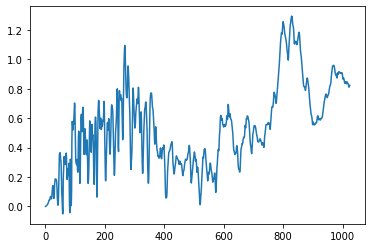

In [ ]:
plt.plot(probingSamples[300][:])
plt.show()

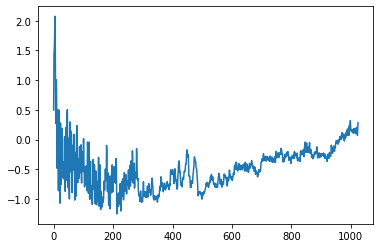

In [ ]:
plt.plot(X_train[300][:])
